Mounted at /content/drive
Contents of extract_path:
['malaria_dataset']
Found 27558 images belonging to 2 classes.
Found 3132 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 98s 95ms/step - accuracy: 0.5416 - loss: 0.7044 - val_accuracy: 0.5648 - val_loss: 0.6806
Epoch 2/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 76s 88ms/step - accuracy: 0.5920 - loss: 0.6695 - val_accuracy: 0.8040 - val_loss: 0.4626
Epoch 3/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 78s 83ms/step - accuracy: 0.6047 - loss: 0.7448 - val_accuracy: 0.6092 - val_loss: 0.6647
Epoch 4/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 72s 83ms/step - accuracy: 0.6861 - loss: 0.5738 - val_accuracy: 0.9042 - val_loss: 0.2610
Epoch 5/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - accuracy: 0.9371 - loss: 0.1873 - val_accuracy: 0.9215 - val_loss: 0.2464
Epoch 6/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.9440 - loss: 0.1743 - val_accuracy: 0.9317 - val_loss: 0.1978
Epoch 7/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9485 - loss: 0.1566 - val_accuracy: 0.9333 - val_loss: 0.2215
Epoch 8/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.9526 - loss: 0.1500 - val_accurac

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9389 - loss: 0.1685
Test Loss: 0.17263464629650116
Test Accuracy: 0.9396551847457886
Final Training Accuracy: 0.9575077891349792
Final Validation Accuracy: 0.9409323334693909
Final Training Loss: 0.13593654334545135
Final Validation Loss: 0.1893337070941925
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Confusion Matrix:
[[860 793]
 [754 725]]


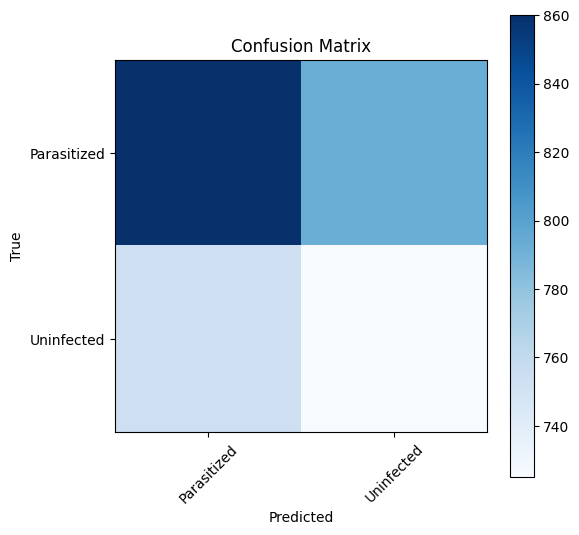

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.53      0.52      0.53      1653
  Uninfected       0.48      0.49      0.48      1479

    accuracy                           0.51      3132
   macro avg       0.51      0.51      0.51      3132
weighted avg       0.51      0.51      0.51      3132



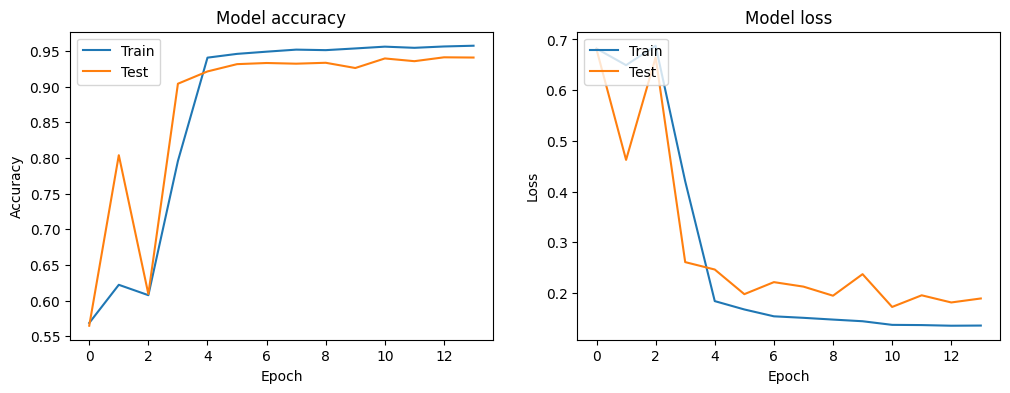

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import zipfile

# Unzip the dataset
zip_path = '/content/drive/My Drive/malaria_dataset.zip'
extract_path = '/content/malaria_dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction and list contents
print("Contents of extract_path:")
print(os.listdir(extract_path))

# Define paths
dataset_dir = os.path.join(extract_path, 'malaria_dataset')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Check if train and test directories exist
if not os.path.isdir(train_dir) or not os.path.isdir(test_dir):
    print("Error: Train or test directory not found.")
else:
    # Image Data Generators
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(64, 64),
                                                        batch_size=32,
                                                        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size=(64, 64),
                                                      batch_size=32,
                                                      class_mode='binary')

    # U-Net Model Architecture
    inputs = Input((64, 64, 3))

    # Encoder path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1], axis=3)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Output layer for binary classification
    flatten = Flatten()(c7)
    fc1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(fc1)
    output = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=[inputs], outputs=[output])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Model Training
    history = model.fit(train_generator,
                        epochs=20,
                        validation_data=test_generator,
                        callbacks=[early_stopping])

    # Save the model
    model_save_path = '/content/drive/My Drive/model/malaria_unet_classifier.h5'
    model.save(model_save_path)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_acc}')

    # Extract final accuracy and loss values
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f'Final Training Accuracy: {final_train_accuracy}')
    print(f'Final Validation Accuracy: {final_val_accuracy}')
    print(f'Final Training Loss: {final_train_loss}')
    print(f'Final Validation Loss: {final_val_loss}')

    # Predicting the Test set results
    Y_pred = model.predict(test_generator)
    y_pred = np.round(Y_pred).astype(int)

    # Confusion Matrix and Classification Report
    print('Confusion Matrix:')
    cm = confusion_matrix(test_generator.classes, y_pred)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(test_generator.class_indices))
    plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
    plt.yticks(tick_marks, test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    target_names = ['Parasitized', 'Uninfected']
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


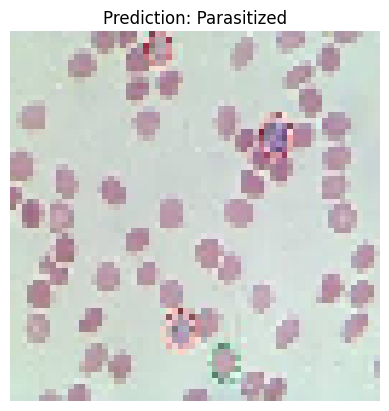

In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to test
image_path = '/content/drive/My Drive/malaria_testing/images.jpg'  # Replace with the path to your image

# Load and preprocess the image
img = load_img(image_path, target_size=(64, 64))  # Resize to the input size expected by the model
img_array = img_to_array(img) / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape (1, 64, 64, 3)

# Load your model
model_path = '/content/drive/My Drive/model/malaria_unet_classifier.h5'
model = tf.keras.models.load_model(model_path)

# Make a prediction
prediction = model.predict(img_array)

# Interpret the prediction
class_names = ['Parasitized', 'Uninfected']
predicted_class = class_names[int(np.round(prediction[0][0]))]  # Binary classification (0 or 1)

# Display the image and prediction
plt.imshow(img)
plt.title(f'Prediction: {predicted_class}')
plt.axis('off')
plt.show()
